In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet
# !pip install anchor-exp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'dataset/explain_te-master/selected/'

file = 'diaretino.csv'
class_names = [0, 1]
_class = 'dr'

In [4]:
df = pd.read_csv(dataset_folder + file)
df.replace(('yes', 'no'), (1, 0), inplace=True)
df.head()

,qa,ps,ma0.5,ma0.6,ma0.7,ma0.8,ma0.9,ma1.0,ex0.5,ex0.6,ex0.7,ex0.8,ex0.9,ex1.0,exm1,exm2,eucmac,diaopt,amfm,dr
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      1151 non-null   int64  
 1   ps      1151 non-null   int64  
 2   ma0.5   1151 non-null   int64  
 3   ma0.6   1151 non-null   int64  
 4   ma0.7   1151 non-null   int64  
 5   ma0.8   1151 non-null   int64  
 6   ma0.9   1151 non-null   int64  
 7   ma1.0   1151 non-null   int64  
 8   ex0.5   1151 non-null   float64
 9   ex0.6   1151 non-null   float64
 10  ex0.7   1151 non-null   float64
 11  ex0.8   1151 non-null   float64
 12  ex0.9   1151 non-null   float64
 13  ex1.0   1151 non-null   float64
 14  exm1    1151 non-null   float64
 15  exm2    1151 non-null   float64
 16  eucmac  1151 non-null   float64
 17  diaopt  1151 non-null   float64
 18  amfm    1151 non-null   int64  
 19  dr      1151 non-null   int64  
dtypes: float64(10), int64(10)
memory usage: 180.0 KB


In [6]:
X, y = df.drop(columns=[_class]), df[_class]

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [8]:
x_test.shape

(346, 19)

In [9]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 834 to 1126
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qa      805 non-null    int64  
 1   ps      805 non-null    int64  
 2   ma0.5   805 non-null    int64  
 3   ma0.6   805 non-null    int64  
 4   ma0.7   805 non-null    int64  
 5   ma0.8   805 non-null    int64  
 6   ma0.9   805 non-null    int64  
 7   ma1.0   805 non-null    int64  
 8   ex0.5   805 non-null    float64
 9   ex0.6   805 non-null    float64
 10  ex0.7   805 non-null    float64
 11  ex0.8   805 non-null    float64
 12  ex0.9   805 non-null    float64
 13  ex1.0   805 non-null    float64
 14  exm1    805 non-null    float64
 15  exm2    805 non-null    float64
 16  eucmac  805 non-null    float64
 17  diaopt  805 non-null    float64
 18  amfm    805 non-null    int64  
dtypes: float64(10), int64(9)
memory usage: 125.8 KB


# ML Model

In [10]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [12]:
random_state=42

In [13]:
x_train

,qa,ps,ma0.5,ma0.6,ma0.7,ma0.8,ma0.9,ma1.0,ex0.5,ex0.6,ex0.7,ex0.8,ex0.9,ex1.0,exm1,exm2,eucmac,diaopt,amfm
834,1,1,85,73,70,62,59,37,43.873596,17.321847,4.708070,1.229496,0.119951,0.015783,0.014205,0.012626,0.548025,0.107324,0
29,1,1,103,89,83,71,60,38,11.025085,3.762343,0.015592,0.010914,0.003118,0.003118,0.001559,0.001559,0.488566,0.134091,0
745,1,1,12,11,11,11,10,8,73.975723,39.190608,6.678279,0.779589,0.121811,0.014211,0.000000,0.000000,0.475377,0.117750,0
165,1,1,19,19,19,18,15,9,13.115054,5.845388,0.154330,0.050435,0.000000,0.000000,0.000000,0.000000,0.484477,0.109948,0
248,1,1,58,57,55,50,43,34,31.499303,16.223873,7.405699,0.924929,0.163038,0.083087,0.026650,0.010974,0.519667,0.125414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1,1,18,18,18,17,13,10,22.320425,10.157700,0.657133,0.044193,0.007686,0.003843,0.000000,0.000000,0.570065,0.090308,1
1095,1,1,34,34,34,34,33,24,136.285159,25.909910,15.509432,5.114110,0.307383,0.048480,0.000000,0.000000,0.523087,0.129967,1
1130,1,1,37,36,33,24,18,10,37.686807,4.978201,1.180336,0.184896,0.024986,0.007996,0.000000,0.000000,0.535271,0.093947,0
860,1,1,11,7,6,6,6,5,31.073428,14.277795,1.746907,0.010051,0.000000,0.000000,0.000000,0.000000,0.531741,0.133682,0


In [14]:
def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        f1, acc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred)
        data.append([name, f1, acc])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.'])
    df = df.sort_values(by=['F1'])
    return df

In [15]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)

clfs = [(rf, 'rf', True)]
dataset = x_train, y_train, x_test, y_test
classify_report(clfs, dataset)

,Name,F1,Acc.
0,rf,0.681948,0.679191


# RF Importance

In [16]:
selected_model = rf

class_names = ['NO','YES']
feature_names = x_train.columns.to_list()

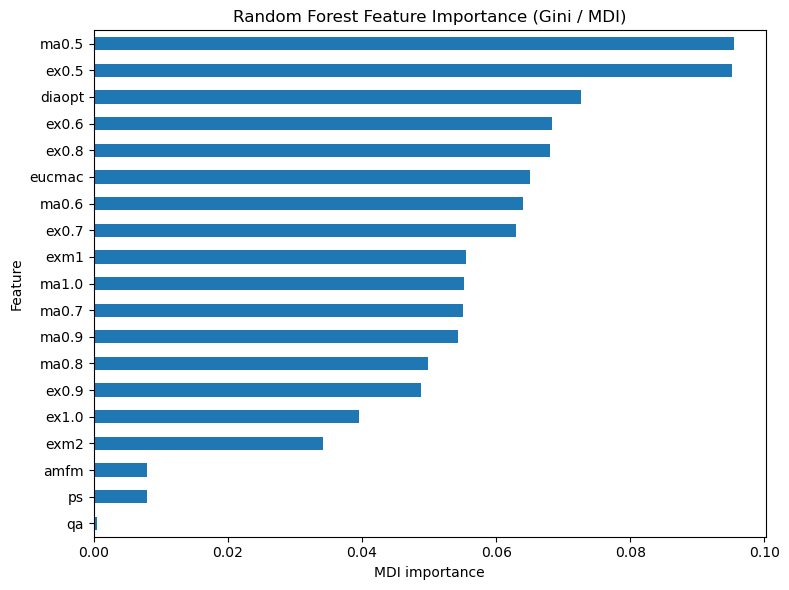

In [17]:
# If selected_model is a Pipeline, grab its final estimator for feature_importances_
final_est = getattr(selected_model, "steps", None)
final_est = final_est[-1][1] if final_est else selected_model

if not hasattr(final_est, "feature_importances_"):
    raise ValueError("Current estimator does not expose .feature_importances_ (MDI).")

gini_series = pd.Series(final_est.feature_importances_, index=feature_names)
gini_series = gini_series.sort_values(ascending=True)

ax = gini_series.plot.barh(figsize=(8, 6))
ax.set_title("Random Forest Feature Importance (Gini / MDI)")
ax.set_xlabel("MDI importance")
ax.set_ylabel("Feature")
plt.tight_layout()
# plt.savefig("figs_global_importance/focal_model_gini_importance.png", dpi=300)
plt.show()


Elapsed time to compute the importances: 1.411 seconds


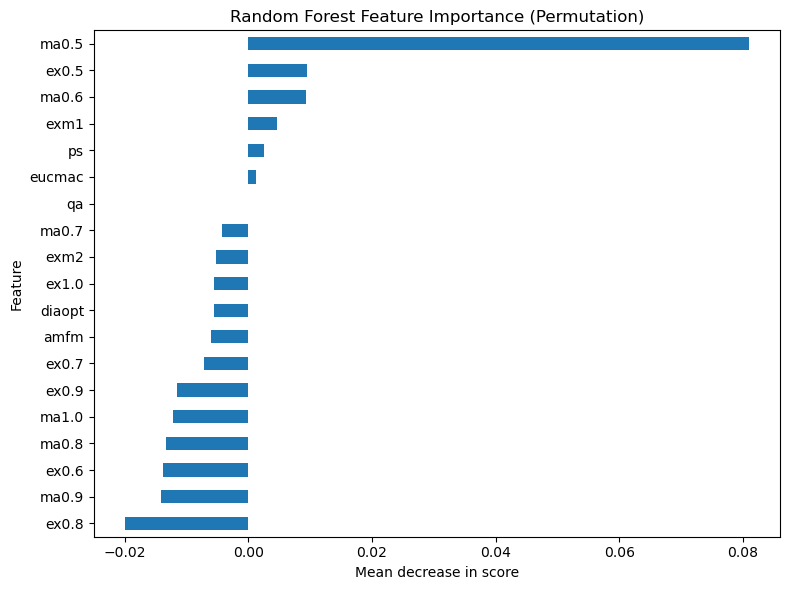

In [18]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    selected_model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

selected_model_importances = pd.Series(
    result.importances_mean, index=feature_names
).sort_values(ascending=True)

ax = selected_model_importances.plot.barh(figsize=(8, 6))
ax.set_title("Random Forest Feature Importance (Permutation)")
ax.set_xlabel("Mean decrease in score")
ax.set_ylabel("Feature")
plt.tight_layout()
# plt.savefig("figs_global_importance/focal_model_permutation_importance.png", dpi=300)
plt.show()